## Surface slope method



In [416]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import icepyx as ipx
import h5py
import geopandas as gpd
from pyproj import Transformer
import re
import glob
import ee
import geemap
import xarray as xr
from datetime import datetime,timedelta
import cartopy.crs as ccrs
# import salem
from pyproj import CRS
from scipy import interpolate

%matplotlib inline

In [4]:
### Functions 

## Reprojection using pyproj
def reproj(X, Y, source_epsg, target_epsg):
    lon = []
    lat = []
    transformer = Transformer.from_crs(source_epsg, target_epsg, always_xy=True)

    if len(X) == len(Y):
        for i in range(len(X)):
            lon1, lat1 = transformer.transform(X[i], Y[i])
            lon.append(lon1)
            lat.append(lat1)
    else:
        raise ValueError("X and Y must be of the same length.")
    return lon, lat


## Read ATL06 data and convert it to geodataframe
def read_atl06(f_name):
    f = h5py.File(f_name, "r")
    
    ## Following code come from ICESat-2 hackweek 2022 tutorial: https://github.com/ICESAT-2HackWeek/website2022/tree/main/book/tutorials/geospatial
    
    IS2_atl06_beams = []
    for key in f.keys():
        if key.startswith("gt"):
            # check if subsetted beam contains land ice data
            try:
                f[key]['land_ice_segments']['segment_id']
            except KeyError:
                pass
            else:
                IS2_atl06_beams.append(key)
            
    
    DEFAULT_GROUPS = []
    DEFAULT_GROUPS.append('bias_correction')
    DEFAULT_GROUPS.append('dem')
    DEFAULT_GROUPS.append('fit_statistics')
    DEFAULT_GROUPS.append('geophysical')
    DEFAULT_GROUPS.append('ground_track')
    
    groups=DEFAULT_GROUPS
    
    # output GeoDataFrame for ICESat-2 ATL06 variables
    gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy([],[]), crs="EPSG:4326")
    
    # read each input beam within the file
    for gtx in IS2_atl06_beams:
        # get each HDF5 variable in ICESat-2 land_ice_segments Group
        columns = {}
        for key,val in f[gtx]['land_ice_segments'].items():
            if isinstance(val, h5py.Dataset):
                if val.attrs.get('_FillValue'):
                    columns[key] = val[:].astype('f')
                    columns[key][val[:] == val.fillvalue] = np.nan
                else:
                    columns[key] = val[:]
            elif isinstance(val, h5py.Group) and (val.name.split('/')[-1] in groups):
                for k,v in val.items():
                    if v.attrs.get('_FillValue'):
                        columns[k] = v[:].astype('f')
                        columns[k][v[:] == v.fillvalue] = np.nan
                    else:
                        columns[k] = v[:]
        # number of segments
        n_seg = f[gtx]['land_ice_segments']['h_li'].size
        # fill value
        # generate derived variables
        columns['rgt'] = np.full((n_seg),f['orbit_info']['rgt'][0])
        columns['cycle_number'] = np.full((n_seg),f['orbit_info']['cycle_number'][0])
        BP,LR = re.findall(r'gt(\d)([lr])',gtx).pop()
        columns['BP'] = np.full((n_seg),int(BP))
        columns['LR'] = [LR]*n_seg
        beam_type = f[gtx].attrs['atlas_beam_type'].decode('utf-8')
        columns['beam_type'] = [beam_type]*n_seg
        columns['spot'] = np.full((n_seg),f[gtx].attrs['atlas_spot_number'])
        # convert from dictionary to geodataframe
        delta_time = (columns['delta_time']*1e9).astype('timedelta64[ns]')
        atlas_sdp_epoch = np.datetime64('2018-01-01T00:00:00Z')
        columns['time'] = gpd.pd.to_datetime(atlas_sdp_epoch + delta_time)
        # generate geometry column
        geometry = gpd.points_from_xy(columns['longitude'], columns['latitude'])
        del columns['longitude']
        del columns['latitude']
        # create Pandas DataFrame object
        df = gpd.pd.DataFrame(columns)
        # append to GeoDataFrame
        gdf = pd.concat([gdf, gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")])
    
    # Reproject to polar stereographic
    coords = np.stack(gdf.geometry.apply(lambda x: np.array(x.coords).ravel()))
    gdf["x"], gdf["y"] = reproj(coords[:, 0], coords[:, 1], "epsg:4326", "epsg:3413")
    # gdf["lon"] = coords[:, 0]
    # gdf["lat"] = coords[:, 1]

    return gdf

In [159]:
## Define ICESat-2 Data object to query
short_name = 'ATL11'
spatial_extent = [-61, 75, -58, 83]
date_range = ['2019-12-01','2020-03-01']

region_a = ipx.Query(short_name, spatial_extent, date_range, tracks='0582')
region_a.avail_granules(ids=True)
# (there are two granules because the petermann glacier is right on the edge of the ICESat-2 regions) we will combine the
# data later to make it as if it was from a single file

[['ATL11_058203_0323_006_08.h5', 'ATL11_058204_0323_006_08.h5']]

In [160]:
#download iceesat files
region_a.order_granules()
path = 'data/ATL11_Petermann/'
region_a.download_granules(path)

Total number of data order requests is  1  for  2  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000005734240
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000005734240 of  1  order(s) is downloaded.
Download complete


In [141]:
# f_name = '/home/jovyan/ICESat-2_hackweek/GroundingLine-Greenland/data/ATL06_Petermann/processed_ATL11_020104_0323_006_08.h5'
# f = h5py.File(f_name, "r")

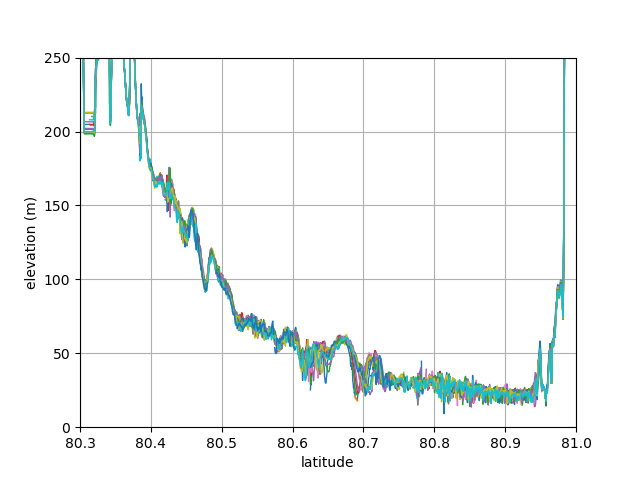

In [403]:
%matplotlib widget

# plot the elevations from all the cycles for each filename
f.keys()
pairtrack = 'pt3'
# f['pt2'].keys()
fig,axs = plt.subplots()
# f['pt2/ref_surf'].keys()
filenames = glob.glob('/home/jovyan/ICESat-2_hackweek/GroundingLine-Greenland/data/ATL11_Petermann/processed_ATL11_0582*.h5')
for k,filename in enumerate(filenames): # we need to loop through all the cycles for each filename
    f = h5py.File(filename, "r") #pull out the h5 data
    if k==1: # this allows us to collect all the data from both files into combined variables
        tidetemp = f[pairtrack+'/cycle_stats/tide_ocean'][:]
        final_tide = np.concatenate((tide,tidetemp))
        deltimetemp = f[pairtrack+'/delta_time'][:]
        final_time = np.concatenate((deltimetemp,deltime))
        latstemp = f[pairtrack]['latitude'][:]
        h_corr_temp = f[pairtrack]['h_corr'][:]
        h_corr_temp[h_corr_temp>1000000]=np.nan
        h_corr_final = np.concatenate((h_corr_temp,h_corr))
        final_lats = np.concatenate((latstemp,lats))
    lats = f[pairtrack]['latitude'][:]
    lons = f[pairtrack]['longitude'][:]
    h_corr = f[pairtrack]['h_corr'][:] # this is the parameter we care about - elevation
    x_atc = f[pairtrack+'/ref_surf/x_atc'][:]
    h_corr[h_corr>1000000]=np.nan # turn the fill value into nans
    deltime = f[pairtrack+'/delta_time'][:]
    for ind in np.arange(h_corr.shape[1]):
        axs.plot(lats,h_corr[:,ind],label = 'cycle' + str(ind),linewidth=1)
axs.set_xlim([80.3,81])
# axs2 = axs.twinx()
axs.grid()
# axs2.plot(final_lats,h_mean,color='red')
axs.set_ylim([0,250])
axs.set_xlabel('latitude')
axs.set_ylabel('elevation (m)')
plt.show()



In [456]:
# filename = filenames[0]
# %matplotlib widget


# f.keys()
# pairtrack = 'pt3'
# # f['pt2'].keys()
# fig,axs = plt.subplots()
# # f['pt2/ref_surf'].keys()
# filenames = glob.glob('/home/jovyan/ICESat-2_hackweek/GroundingLine-Greenland/data/ATL11_Petermann/processed_ATL11_0582*.h5')
# filename = filenames[0]
# f = h5py.File(filename, "r")

# lats = f[pairtrack]['latitude'][:]
# lats




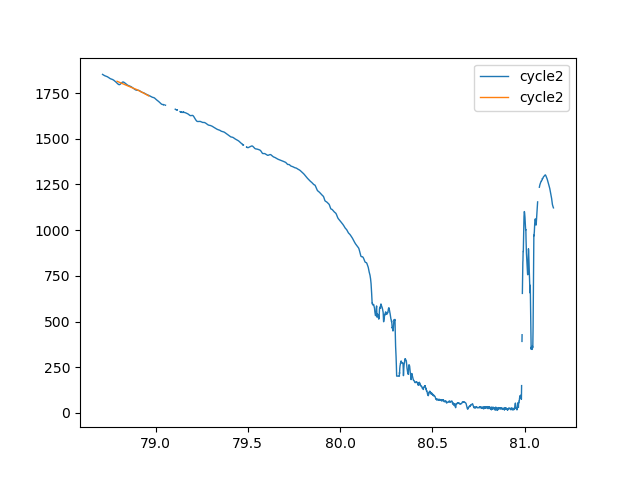

In [415]:
#this is to plot 
fig,axs = plt.subplots()
# for ind in np.arange(3):
ind=2
axs.plot(final_lats,h_corr_final[:,ind],label = 'cycle' + str(ind),linewidth=1)
axs.plot(final_lats[int(binsize/2)-1:-int(binsize/2)],running_mean(h_corr_final[:,ind],binsize),label = 'cycle' + str(ind),linewidth=1)

axs.legend()


In [510]:
# running mean function 
# def running_mean(x, N):
#     cumsum = np.cumsum(np.insert(x, 0, 0)) 
#     return (cumsum[N:] - cumsum[:-N]) / float(N)

def moving_average(a, n=5):
    ret = np.cumsum(a.filled(0))
    ret[n:] = ret[n:] - ret[:-n]
    counts = np.cumsum(~a.mask)
    counts[n:] = counts[n:] - counts[:-n]
    ret[~a.mask] /= counts[~a.mask]
    ret[a.mask] = np.nan

    return ret


In [509]:
# # here we take the running mean of multiple cycles of h_corr data , then take the average of that smoothed data
# # and then find the slope 
# fig,axs = plt.subplots()
# binsize = 300 # running mean bin
# for ind in np.arange(13): # 13 is number of cycles you want
#     if ind==1:
#         smoothies = h_corr_smooth # smoothies will be all the smoothed data in one array
#     h_corr_masked = np.ma.masked_array(h_corr_final[:,ind],np.isnan(h_corr_final[:,ind])) # we need to mask the h_corr nans
#     h_corr_smooth = moving_average(h_corr_masked,binsize) # find the running mean
#     if ind>1:
#         smoothies = np.vstack((smoothies,h_corr_smooth)) # concatenate the smoothed data
#     axs.plot(final_lats[int(binsize/2)-1:-int(binsize/2)],h_corr_smooth,label = 'cycle' + str(ind),linewidth=1) # plot the smoothed data
# axs2 = axs.twinx()
# h_corr_smooth_mean = np.nanmean(smoothies,axis=0) # take the mean of all the smoothed data
# axs2.plot(final_lats[int(binsize/2)-1:-int(binsize/2)], h_corr_smooth_mean,color='red')
# axs.set_xlim([80,81])
# axs.plot(final_lats[int(binsize/2)-1:-int(binsize/2)],h_corr_smooth_mean,color='green')
# axs.legend()

# # so the h_corr data has enough gaps in it that screw up the running mean, lets test an interpolation

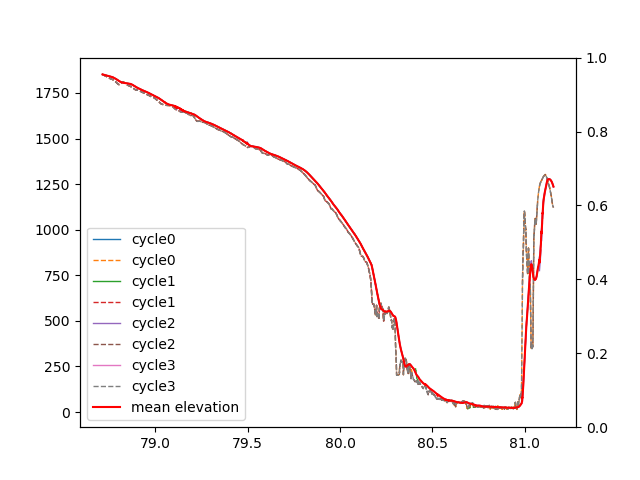

In [501]:
# interpolating each h_corr before taking the running mean
%matplotlib widget

fig,axs = plt.subplots()
binsize = 100 # running mean bin
c = 4
for ind in np.arange(c): # c is number of cycles you want
    if ind==1:
        smoothies = h_corr_smooth # smoothies will be all the smoothed data in one array
    f = interpolate.interp1d(final_lats,h_corr_final[:,ind]) # create the interpolant
    h_corr_filled = f(final_lats[1::]-.0000001) #interpolate, this will force there to be a non-nan value at every lat
    h_corr_masked = np.ma.masked_array(h_corr_filled,np.isnan(h_corr_filled)) # we need to mask the h_corr nans
    h_corr_smooth = moving_average(h_corr_masked,n=binsize) # find the running mean
    if ind>1:
        smoothies = np.vstack((smoothies,h_corr_smooth)) # concatenate the smoothed data
    axs.plot(final_lats[1::],h_corr_smooth,label = 'cycle' + str(ind),linewidth=1) # plot the smoothed data
    axs.plot(final_lats[1::],h_corr_filled,'--',label = 'cycle' + str(ind),linewidth=1) # plot the smoothed data

axs2 = axs.twinx()
h_corr_smooth_mean = np.nanmean(smoothies,axis=0) # take the mean of all the smoothed data
axs.plot(final_lats[1::], h_corr_smooth_mean,color='red',label='mean elevation')
# axs.set_xlim([80,81])
# axs.plot(final_lats[int(binsize/2):-int(binsize/2)],h_corr_smooth_mean,color='green')
axs.legend()

In [497]:
h_corr_masked.shape
h_corr_final.shape

(4638, 21)

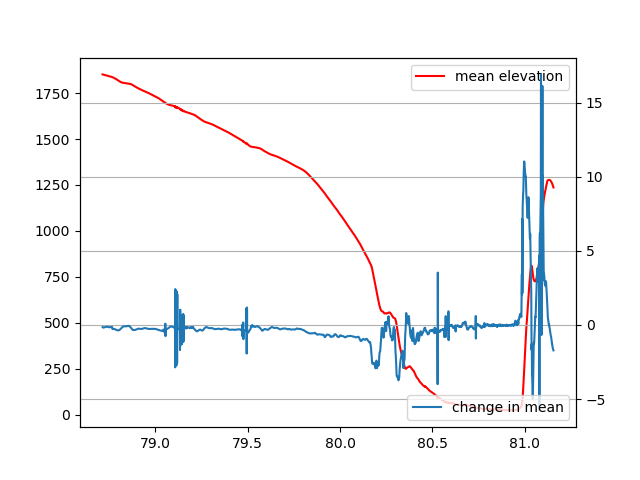

In [508]:
# now lets look at the elevation change v. the rate of elevation change
fig,axs = plt.subplots()
axs.plot(final_lats[1::], h_corr_smooth_mean,color='red',label='mean elevation') # replot mean elevation
axs2 = axs.twinx()
axs2.plot(final_lats[1::], np.gradient(h_corr_smooth_mean),label = 'change in mean')
axs2.grid()
axs.legend()
axs2.legend(loc='lower right')


In [514]:
# calculate elevation anomalies, using the smoothed data

h_anomalies = np.zeros(smoothies.shape) # initialize matrix to fill
for ind in np.arange(smoothies.shape[0]):
    h_anomalies[ind,:] = smoothies[ind,:] - h_corr_smooth_mean

(-5.0, 5.0)

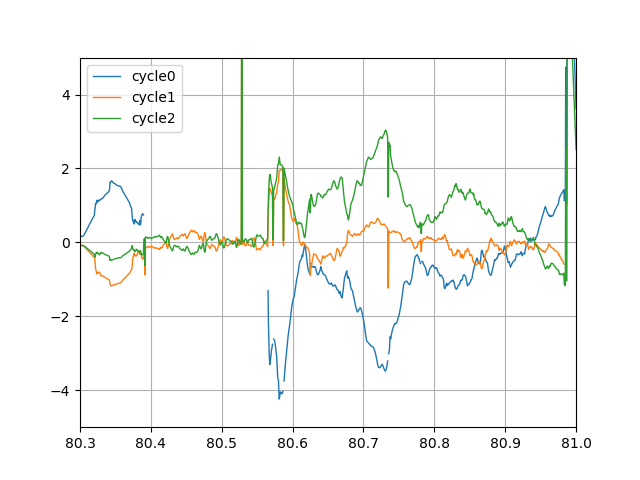

In [519]:
# plot elevation anomalies

fig,axs = plt.subplots()

for ind in np.arange(h_anomalies.shape[0]):
    axs.plot(final_lats[1::],h_anomalies[ind,:],label = 'cycle' + str(ind),linewidth=1)
    # deltime = f['pt2/delta_time'][:]

axs.set_xlim([80.3,81])
axs.set_ylim([-25,25])
axs.grid()
axs.legend()
# axs2 = axs.twinx()
# axs2.plot(final_lats,np.nanmean(h_anomalies,axis=1),color='red')
axs.set_ylim([-5,5])

# plt.show()



78.71300691214034
78.71300691214034


Text(88.56944444444443, 0.5, 'elevation (m)')

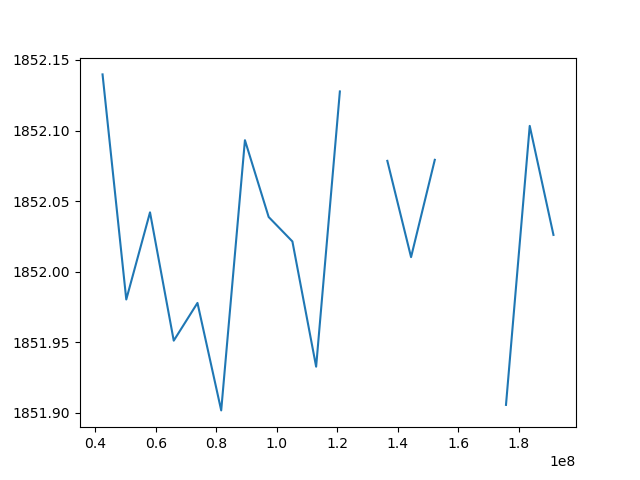

In [538]:
# plot one latitude changing over time

latind = 0 # pick you latitude
print(final_lats[latind])
fig,ax = plt.subplots()
print(final_lats[latind])
ax.plot(final_time[latind,:],h_corr_final[latind,:])
axs.set_xlabel('time (s since 2018-01-01)')
axs.set_ylabel('elevation (m)')


In [540]:
# test=[datetime(2018,1,1)+timedelta(seconds=int(a)) for a in final_time[0,:]]
# temp = int(final_time[0,:][2])
# datetime(2018,1,1)+timedelta(seconds=temp)

In [542]:
# fig,axs = plt.subplots()
# c=0
# for ind in np.arange(h_corr.shape[1]):
#     # print(ind)
#     # t = datetime(2018,1,1)+ timedelta(seconds = time[0,ind])
#     # axs.plot(x_atc,h_corr[:,ind],label = t.strftime('%m/%d/%Y'))
#     axs.plot(lats,h_corr[:,ind],label = 'cycle' + str(ind),linewidth=1)
#     c+=1
# axs.set_ylim([200,750])
# plt.show()

# # axs.plot(x_atc,h_corr[:,10],label = 'cycle' + str(ind))

In [541]:
# plt.close('all')
# fig = plt.figure(figsize=(7,7)) #initiate plot
# crs = salem.proj_to_cartopy(CRS.from_epsg(4326))
# axs = plt.axes(projection=crs)
# axs.coastlines(resolution='10m')
# axs.gridlines(draw_labels=True)
# axs.stock_img()
# gdf_dic['20190221'].plot(ax=axs)
# # plt.colorbar(sc1)
# # axs.set_title(str(filename[-35:-27]))
# axs.set_extent([-65,-50,80,82],crs=ccrs.PlateCarree())
# # axs.set_extent([-60,20,60,87],crs=ccrs.PlateCarree())
